## Loading the libraries

In [1]:
import pandas as pd
from nltk.corpus import stopwords
import functions
import nltk
nltk.download('stopwords')

# For plotting 
import seaborn as sns

# Model Implementation
import tensorflow as tf
import numpy as np
import xgboost as xgb
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras import Model
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
print(xgb.__version__)

# Used for comparing RNN and CNN
from keras.preprocessing import sequence


[nltk_data] Downloading package stopwords to /Users/adn-
[nltk_data]     mbp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2.1.1


## Loading the dataset

In [2]:
train_data = pd.read_csv('Dataset/train.csv')

In [3]:
train_data = train_data[:10000]

In [4]:
test_data = pd.read_csv('dataset/test.csv')

## Merging the train and test data together

In [5]:
dataset = pd.concat([train_data, test_data], axis = 0)

In [6]:
new_dataset = dataset.drop_duplicates()

In [7]:
# updating the dataset's index after removing duplicates

new_dataset.index = range(new_dataset.index.size)

In [8]:
new_dataset['Genre'].unique()

array(['Rock', 'Metal', 'Pop', 'Indie', 'R&B', 'Hip-Hop', 'Country',
       'Jazz', 'Electronic', 'Folk'], dtype=object)

In [9]:
# Storing the Music Genre Names into a variable
class_names = ['pop', 'rock', 'country', 'electronic', 'hip-hop']

In [10]:
new_dataset = new_dataset[
    (new_dataset['Genre'] == 'Hip-Hop') |
    (new_dataset['Genre'] == 'Pop') |
    (new_dataset['Genre'] == 'Country') |
    (new_dataset['Genre'] == 'Rock') |
    (new_dataset['Genre'] == 'Electronic')
]

In [11]:
new_dataset['Lyrics'] = new_dataset['Lyrics'].astype(str)

In [12]:
new_dataset['Lyrics'] = functions.clean_data(new_dataset['Lyrics'])

# Data Preprocessing

In [13]:
# Removing songs with no lyrics

new_dataset = new_dataset.drop(
    new_dataset[new_dataset['Lyrics'].str.len() == 0].index
)

In [14]:
# Grouping the data by artist and genre

new_dataset.groupby('Genre')['Song'].count()

Genre
Country        810
Electronic     660
Hip-Hop        960
Pop           2557
Rock          6940
Name: Song, dtype: int64

In [15]:
minimum_songs = min(new_dataset.groupby('Genre')['Song'].count())
minimum_songs

660

In [16]:
# Iterating over each unique genre in the 'Genre' column of the dataset
for genre in new_dataset['Genre'].unique():
    
    # Checking if the number of songs in the current genre is less than twice the minimum number of songs in any genre
    if new_dataset[new_dataset['Genre'] == genre]['Song'].size < (2 * minimum_songs):
        
        # Creating a copy of all rows in the dataset that belongs to the current genre
        data_copy = new_dataset[new_dataset['Genre'] == genre].copy()
        
        # Concatenate the copied rows back to the original dataset
        new_dataset = pd.concat([new_dataset, data_copy], axis=0)

In [17]:
# Reset the index of the DataFrame to a sequential integer range starting from 0

new_dataset.index = range(new_dataset.index.size)

In [18]:
for genre in new_dataset['Genre'].unique():
  maxID = new_dataset[new_dataset['Genre'] == genre].index[2 * minimum_songs - 1]
  new_dataset = new_dataset.drop(new_dataset[(new_dataset['Genre'] == genre) & (new_dataset.index > maxID)].index) # remove songs of genres with too much songs

In [19]:
new_dataset.groupby('Genre')['Song'].count()

Genre
Country       1320
Electronic    1320
Hip-Hop       1320
Pop           1320
Rock          1320
Name: Song, dtype: int64

# Tokenization and removal of unnecessary words

In [20]:
new_dataset['Lyrics'] = functions.split_data(new_dataset['Lyrics'])

In [21]:
stop_words = set(stopwords.words('english'))
new_songs = []
for value in new_dataset['Lyrics']:
  value = [w for w in value if not w in stop_words]
  new_songs.append(value)
new_dataset['Lyrics'] = new_songs

In [22]:
new_dataset = new_dataset[['Lyrics', 'Genre']]
new_dataset.head()

,Lyrics,Genre
0,"[starts, pain, , followed, hate, fueled, endle...",Rock
1,"[freedom, , alone, alone, patiently, waiting, ...",Rock
2,"[biting, hand, feeds, , lying, voice, inside, ...",Rock
3,"[say, know, cant, imagine, waits, across, line...",Rock
4,"[heart, beating, faster, cant, control, feelin...",Rock


In [23]:
new_dataset.to_csv('clean_data.csv', index = False)

# Implementing models

In [24]:
dataset = pd.read_csv(
    'clean_data.csv',
    converters = {
        'Lyrics': literal_eval
    }
)

In [25]:
lyrics = dataset['Lyrics']
genre = dataset['Genre']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    lyrics, genre, test_size=0.25, random_state=42, stratify = genre
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify = y_train
)

In [27]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (3712,)
Shape of X_val:  (1238,)
Shape of X_test:  (1650,)
Shape of y_train:  (3712,)
Shape of y_val:  (1238,)
Shape of y_test:  (1650,)


## Implemeting tf-idf

In [28]:
stopwords = functions.create_vocab(X_train, 10000)
stopwords_len = len(stopwords)

In [29]:
# to each word assigns a ratio of documents in which the word is present
def create_doc_frequencies(data):
  docFrequencies = {}
  numDocuments = X_train.shape[0]
  for word in stopwords:
    docFrequency = 0
    for text in data:
      if word in text:
        docFrequency += 1
    docFrequencies[word] = docFrequency / numDocuments
  return docFrequencies

In [30]:
docFrequencies = create_doc_frequencies(X_train)

In [31]:
# creates tf-idf representations of given data from given document frequencies
def create_tf_idf(data, docFrequencies):  
  newData = []
  docFrequenciesList = list(docFrequencies.values())
  for text in data:
    bag = [0] * stopwords_len
    for word in text:
      if word in stopwords:
        bag[stopwords[word]] += 1 # bag of words representation
    for i in range(len(bag)):
      bag[i] = bag[i] / len(text) # term frequency representation
      bag[i] = bag[i] * np.log(1 / docFrequenciesList[i]) # tf-idf representation
    newData.append(bag)
  return newData

In [32]:
X_train = create_tf_idf(X_train, docFrequencies)
X_val = create_tf_idf(X_val, docFrequencies)
X_test = create_tf_idf(X_test, docFrequencies)

In [33]:
# Representation of the explained variable
y_train = y_train.apply(lambda x: functions.genre_to_class[x])
y_val = y_val.apply(lambda x: functions.genre_to_class[x])
y_test = y_test.apply(lambda x: functions.genre_to_class[x])

In [34]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [35]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (3712, 10000)
Shape of X_val:  (1238, 10000)
Shape of X_test:  (1650, 10000)
Shape of y_train:  (3712,)
Shape of y_val:  (1238,)
Shape of y_test:  (1650,)


## Implementing Deep Neural Network Model Algorithm

In [36]:
def func_model():
    input_layer = Input(shape=(stopwords_len,))
    flatten = Flatten()(input_layer)
    dense1 = Dense(1024, activation='relu')(flatten)
    dropout1 = Dropout(rate=0.2)(dense1)
    dense2 = Dense(1024, activation='relu')(dropout1)
    dropout2 = Dropout(rate=0.2)(dense2)
    concat = Concatenate()([dense1, dense2, dropout1, dropout2])
    output_layer = Dense(5, activation='softmax')(concat)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [37]:
model_DNN = func_model()

In [38]:
model_DNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10000)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 10,241,024 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  1,049,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096)      │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │     20,485 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,311,109 (43.15 MB)

 Trainable params: 11,311,109 (43.15 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# using model checkpoint to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_DNN.keras',  # Path to save the model file with .keras extension
    monitor='val_loss',                 # Metric to monitor
    verbose=1,                          # Verbosity mode (0 or 1)
    save_best_only=True,                # Only save the best model
    mode='min',                         # Mode for the monitored metric
    save_weights_only=False,            # Whether to save only the model weights
    save_freq='epoch'                   # Save every epoch
)

In [40]:
model_DNN.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
history = model_DNN.fit(
    X_train, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose = 1,
    callbacks=[checkpoint]
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2602 - loss: 1.5924
Epoch 1: val_loss improved from inf to 1.45946, saving model to model_checkpoint_DNN.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2642 - loss: 1.5907 - val_accuracy: 0.5000 - val_loss: 1.4595
Epoch 2/10
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7081 - loss: 1.2308
Epoch 2: val_loss improved from 1.45946 to 0.99105, saving model to model_checkpoint_DNN.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7149 - loss: 1.2087 - val_accuracy: 0.6575 - val_loss: 0.9911
Epoch 3/10
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9116 - loss: 0.4062
Epoch 3: val_loss did not improve from 0.99105
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9122 - loss: 0.3973 - val_accuracy: 0.6785 - val_loss: 1.0111
Epoch 4/10
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9781 - loss: 0.0951
Epoch 4: val_loss did not improve from 0.99105
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62

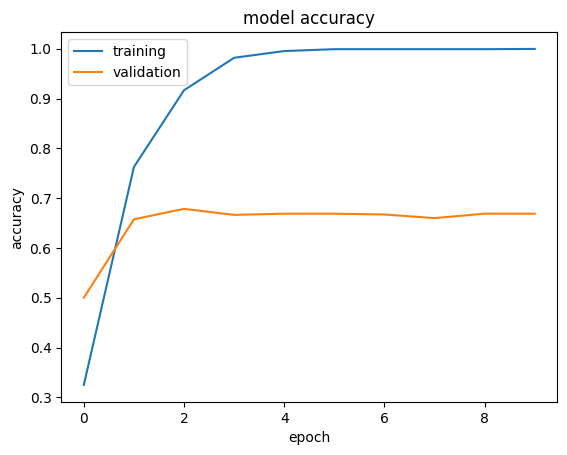

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [43]:
model_DNN.load_weights('model_checkpoint_DNN.keras')

In [44]:
# makes a predictions of given songs
def predict_genre(model, songs):
  songs = functions.clean_data(songs)
  songs = functions.split_data(songs)
  songs = functions.stem(songs)
  songs = functions.remove_stopwords(songs)
  songs = create_tf_idf(songs, docFrequencies)
  songs = np.array(songs)
  return model.predict(songs)

In [45]:
song_lyrics = ['Man, whatever\nDre, just let it run\nAyo, turn the beat up a little bit\nAyo, this song is for anyone...\nFuck it, just shut up and listen, ayo\nI sit back with this pack of Zig-Zags and this bag\nOf this weed, it gives me the shit needed to be\nThe most meanest MC on this on this Earth\nAnd since birth I\'ve been cursed with this curse to just curse\nAnd just blurt this berserk and bizarre shit that works\nAnd it sells and it helps in itself to relieve all this tension\nDispensing these sentences, getting this stress\nThat\'s been eating me recently off of this chest\nAnd I rest again peacefully\nBut at least have the decency in you\nTo leave me alone, when you freaks see me out\nIn the streets when I\'m eating or feeding my daughter\nTo not come and speak to me\nI don\'t know you, and no, I don\'t owe you a mothafuckin\' thing\nI\'m not Mr. N\'Sync, I\'m not what your friends think\nI\'m not Mr. Friendly, I can be a prick if you tempt me\nMy tank is on empty, no patience is in me\nAnd if you offend me, I\'m lifting you ten feet in the air\nI don\'t care who was there and who saw me just jaw you\nGo call you a lawyer, file you a lawsuit\nI\'ll smile in the courtroom and buy you a wardrobe\nI\'m tired of all you, I don\'t mean to be mean\nBut that\'s all I can be, it\'s just me\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am, huh\nI don\'t know, it\'s just the way I am\nSometimes I just feel like my father\nI hate to be bothered with all of this nonsense, it\'s constant\nAnd, oh, it\'s his lyrical content, the song Guilty Conscience\nHas gotten such rotten responses\nAnd all of this controversy circles me\nAnd it seems like the media immediately points a finger at me\nSo I point one back at \'em, but not the index or pinkie\nOr the ring or the thumb, it\'s the one you put up\nWhen you don\'t give a fuck, when you won\'t just put up\nWith the bullshit they pull, \'cause they full of shit too\nWhen a dude\'s getting bullied and shoots up his school\nAnd they blame it on Marilyn and the heroin\nWhere were the parents at? And look where it\'s at!\nMiddle America, now it\'s a tragedy\nNow it\'s so sad to see, an upper-class city\nHavin\' this happenin\'\nThen attack Eminem \'cause I rap this way\nBut I\'m glad, \'cause they feed me the fuel that I need\nFor the fire to burn and it\'s burning, and I have returned\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am\nI\'m so sick and tired of being admired\nThat I wish that I would just die or get fired\nAnd dropped from my label, let\'s stop with the fables\nI\'m not gonna be able to top on "My Name Is"\nAnd pigeon-holed into some poppy sensation\nTo cop me rotation at rock-n-roll stations\nAnd I just do not got the patience\nTo deal with these cocky Caucasians\nWho think I\'m some wigger who just tries to be black\n\'Cause I talk with an accent, and grab on my balls\nSo they always keep asking the same fucking questions\nWhat school did I go to, what hood I grew up in\nThe why, the who, what, when, the where and the how\n\'Til I\'m grabbing my hair and I\'m tearin\' it out\n\'Cause they driving me crazy, I can\'t take it\nI\'m racin\', I\'m pacin\', I stand and I sit\nAnd I\'m thankful for every fan that I get\nBut I can\'t take a shit in the bathroom\nWithout someone standing by it\nNo, I won\'t sign you an autograph\nYou can call me an asshole, I\'m glad, \'cause...\nI am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am']

In [46]:
predict_genre(model_DNN, song_lyrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[0.17391561, 0.25035545, 0.03761308, 0.09011104, 0.44800487]],
      dtype=float32)

In [47]:
# Predict on the test set
y_pred = model_DNN.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [48]:
# Calculate and print Accuracy and loss
dnn_loss, dnn_accuracy = model_DNN.evaluate(X_test, y_test)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6595 - loss: 0.9282


In [49]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

In [50]:
# Calculate additional metrics
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred_classes)
kappa = cohen_kappa_score(y_test, y_pred_classes)# For regression predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred_classes))
rss = np.sum(np.square(y_test - y_pred_classes))
mape = mean_absolute_percentage_error(y_test, y_pred_classes)

# Calculate Sensitivity and Specificity
tp = conf_matrix[1, 1]  # True Positives
tn = conf_matrix[0, 0]  # True Negatives
fp = conf_matrix[0, 1]  # False Positives
fn = conf_matrix[1, 0]  # False Negatives

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

In [51]:
dnn_stats = {
    'Accuracy': dnn_accuracy * 100,
    'Loss': dnn_loss * 100,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Matthews Correlation Coefficient': mcc,
    'Cohen\'s Kappa': kappa,
    'RMSE': rmse,
    'RSS': rss,
    'MAPE': mape,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}

In [52]:
# Print additional metrics
print("Deep Neural Network Model \n---------------------------")
print(f"Accuracy: {dnn_accuracy * 100:.2f}%")
print(f"Loss: {dnn_loss * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"RSS: {rss:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Deep Neural Network Model 
---------------------------
Accuracy: 64.55%
Loss: 95.82%
Precision: 0.65
Recall: 0.65
F1-Score: 0.65
Matthews Correlation Coefficient: 0.56
Cohen's Kappa: 0.56
RMSE: 1.21
RSS: 2422.00
MAPE: 827024658844400.50
Sensitivity (Recall): 0.70
Specificity: 0.62


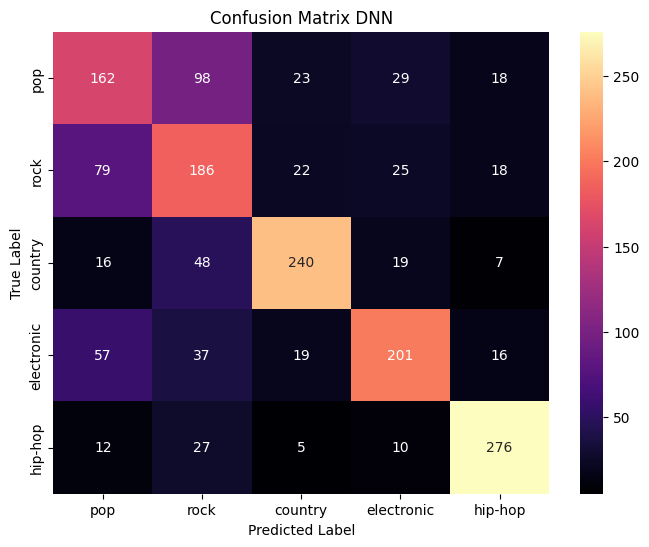

In [53]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix DNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [54]:
# Classification Report
class_report = classification_report(y_test, y_pred_classes)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       330
           1       0.47      0.56      0.51       330
           2       0.78      0.73      0.75       330
           3       0.71      0.61      0.65       330
           4       0.82      0.84      0.83       330

    accuracy                           0.65      1650
   macro avg       0.65      0.65      0.65      1650
weighted avg       0.65      0.65      0.65      1650



## Implementing XGBoost Model

In [55]:
modelXGB = xgb.XGBClassifier(
    use_label_encoder = False,
    eval_metric='mlogloss'
)

modelXGB.fit(X_train, y_train)

/opt/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:44:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [56]:
# Predict on the test set
y_pred = modelXGB.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)

# Make sure to predict probabilities if calculating log loss
y_pred_proba = modelXGB.predict_proba(X_test)

# Calculate log loss, assuming y_test is properly formatted for a classification problem
xgb_loss = log_loss(y_test, y_pred_proba)

In [57]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tp = conf_matrix[1, 1]  # True Positive
fn = conf_matrix[1, 0]  # False Negative
tn = conf_matrix[0, 0]  # True Negative
fp = conf_matrix[0, 1]  # False Positive

# Sensitivity (Recall or True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

In [58]:
xgb_stats = {
    'Accuracy': xgb_accuracy * 100,
    'Loss': xgb_loss * 100,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Matthews Correlation Coefficient': mcc,
    'Cohen\'s Kappa': kappa,
    'RMSE': rmse,
    'RSS': rss,
    'MAPE': mape,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}

In [59]:
print("XGBoost Model \n------------------------------------")
print(f"Accuracy: {xgb_accuracy * 100:.2f}%")
print(f"Log Loss: {xgb_loss:.4f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"RMSE: {rmse}")
print(f"RSS: {rss}")
print(f"MAPE: {mape}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

XGBoost Model 
------------------------------------
Accuracy: 67.64%
Log Loss: 0.8530
Precision: 0.65
Recall: 0.65
F1-Score: 0.65
Matthews Correlation Coefficient: 0.56
Cohen's Kappa: 0.56
RMSE: 1.2115604763604613
RSS: 2422
MAPE: 827024658844400.5
Sensitivity: 0.6748971193415638
Specificity: 0.7208333333333333


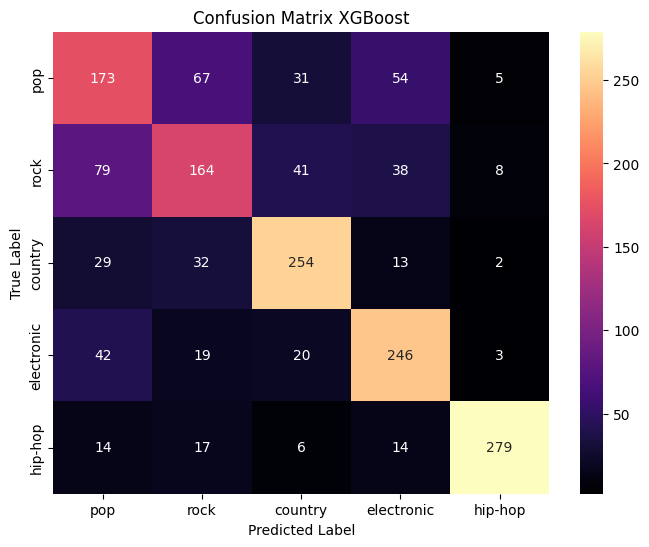

In [60]:
# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [61]:
# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       330
           1       0.55      0.50      0.52       330
           2       0.72      0.77      0.74       330
           3       0.67      0.75      0.71       330
           4       0.94      0.85      0.89       330

    accuracy                           0.68      1650
   macro avg       0.68      0.68      0.68      1650
weighted avg       0.68      0.68      0.68      1650



## Implementing Recurrent Neural Network Model

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    lyrics, genre, test_size=0.25, random_state=42, stratify = genre
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify = y_train
)

In [63]:
vocab = functions.create_vocab(X_train)
vocabSize = len(vocab)

In [64]:
# creates representations where every word is an integer of given data
def integer_encoding(data):
  newData = []
  for text in data:
    newText = []
    for word in text:
      if word not in vocab:
        newText.append(1) # 1 is for word which is not in vocabulary
      if word in vocab and vocab[word] > 0: # 0 is for empty word, we dont want that, 0 will be for padding
        newText.append(vocab[word] + 1)
    newData.append(newText)
  return newData

In [65]:
X_train = integer_encoding(X_train)
X_val = integer_encoding(X_val)
X_test = integer_encoding(X_test)

In [66]:
y_train = y_train.apply(lambda x: functions.genre_to_class[x])
y_val = y_val.apply(lambda x: functions.genre_to_class[x])
y_test = y_test.apply(lambda x: functions.genre_to_class[x])

### Padding

In [67]:
# counts maximum length of given data
def max_len(data):
  maxLen = 0
  for text in data:
    if len(text) > maxLen:
      maxLen = len(text)
  return maxLen

In [68]:
maxLen = max_len(X_train)

In [69]:
X_train = sequence.pad_sequences(X_train, maxLen)
X_val = sequence.pad_sequences(X_val, maxLen)
X_test = sequence.pad_sequences(X_test, maxLen)

### Building the model

In [70]:
def func_model():
  input_layer = Input(shape=(None,), dtype="int64")
  embedding = Embedding(vocabSize + 1, 64)(input_layer)
  lstm = LSTM(64)(embedding)
  output_layer = Dense(5, activation="softmax")(lstm)
  model = Model(inputs=input_layer, outputs=output_layer)
  return model

In [71]:
model_RNN = func_model()

In [72]:
model_RNN.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │     1,764,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,798,149 (6.86 MB)

 Trainable params: 1,798,149 (6.86 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_RNN.keras',  # Path to save the model file with .keras extension
    monitor='val_accuracy',                 # Metric to monitor
    save_best_only=True,                # Only save the best model
    save_weights_only=False,            # Whether to save only the model weights
)

In [74]:
model_RNN.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=['accuracy']
)

In [75]:
history = model_RNN.fit(
    X_train, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose = 1,
    callbacks=[checkpoint]
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2120 - loss: 1.6089 - val_accuracy: 0.2512 - val_loss: 1.6071
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2919 - loss: 1.6035 - val_accuracy: 0.3061 - val_loss: 1.5998
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3638 - loss: 1.5608 - val_accuracy: 0.3756 - val_loss: 1.3894
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4528 - loss: 1.3683 - val_accuracy: 0.3918 - val_loss: 1.3423
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4752 - loss: 1.2897 - val_accuracy: 0.4144 - val_loss: 1.3205
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5105 - loss: 1.2115 - val_accuracy: 0.4443 - val_loss: 1.2801
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5197 - loss: 1.1349 - val_accuracy: 0.4095 - val_loss: 1.3091
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5451 - loss: 1.0789 - val_accuracy: 0.4758 - val_loss:

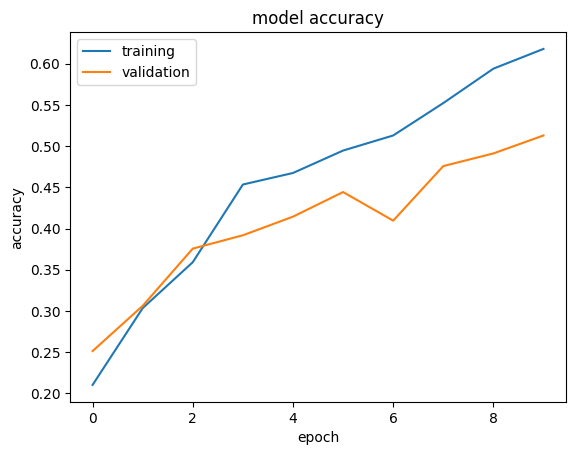

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [77]:
def predict_genre(model, songs):
  songs = functions.clean_data(songs)
  songs = functions.split_data(songs)
  songs = functions.stem(songs)
  songs = functions.remove_stopwords(songs)
  songs = integer_encoding(songs)
  songs = sequence.pad_sequences(songs, maxLen)
  return model.predict(songs)

In [78]:
predict_genre(model_RNN, song_lyrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


array([[0.13287988, 0.17852025, 0.26022395, 0.12793684, 0.30043912]],
      dtype=float32)

In [79]:
# Predict on the test set
y_pred_prob = model_RNN.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


In [80]:
y_test_df = pd.DataFrame(y_test, columns=['Genre'])

# Perform one-hot encoding
y_test_one_hot = pd.get_dummies(y_test_df, columns=['Genre'])

# Get class names
y_test_classes = np.argmax(y_test_one_hot, axis=1)

In [81]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred)

In [82]:
mcc = matthews_corrcoef(y_test, y_pred_classes)
kappa = cohen_kappa_score(y_test, y_pred_classes)
if len(y_pred_proba.shape) == 1 or y_pred_proba.shape[1] == 1:
    y_pred_positive_proba = y_pred_proba.flatten()  # Ensure it's a 1D array
else:
    # Assume the second column corresponds to the positive class probabilities
    y_pred_positive_proba = y_pred_proba[:, 1]  # This is typical for softmax with two outputs

In [83]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_positive_proba))
rss = np.sum(np.square(y_test - y_pred_positive_proba))
mape = mean_absolute_percentage_error(y_test, y_pred_positive_proba)

# Calculate Accuracy (already done during evaluation)
rnn_loss, rnn_accuracy = model_RNN.evaluate(X_test, y_test)

# Calculate additional metrics
precision = precision_score(y_test_classes, y_pred, average='weighted')
recall = recall_score(y_test_classes, y_pred, average='weighted')
f1 = f1_score(y_test_classes, y_pred, average='weighted')

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5485 - loss: 1.1399


In [84]:
rnn_stats = {
    'Accuracy': rnn_accuracy * 100,
    'Loss': rnn_loss * 100,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Matthews Correlation Coefficient': mcc,
    'Cohen\'s Kappa': kappa,
    'RMSE': rmse,
    'RSS': rss,
    'MAPE': mape,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}

In [85]:
print(f"RNN Model \n---------------------------")
print(f"Accuracy: {rnn_accuracy * 100:.2f}%")
print(f"Loss: {rnn_loss * 100:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Matthew's Correlation Coefficient (MCC): {mcc:.3f}")
print(f"Cohen's Kappa: {kappa:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"RSS: {rss:.3f}")
print(f"MAPE: {mape:.3f}")

RNN Model 
---------------------------
Accuracy: 52.61%
Loss: 118.47%
Precision: 0.510
Recall: 0.526
F1-Score: 0.505
Matthew's Correlation Coefficient (MCC): 0.558
Cohen's Kappa: 0.557
RMSE: 2.354
RSS: 9146.040
MAPE: 215438399639905.188


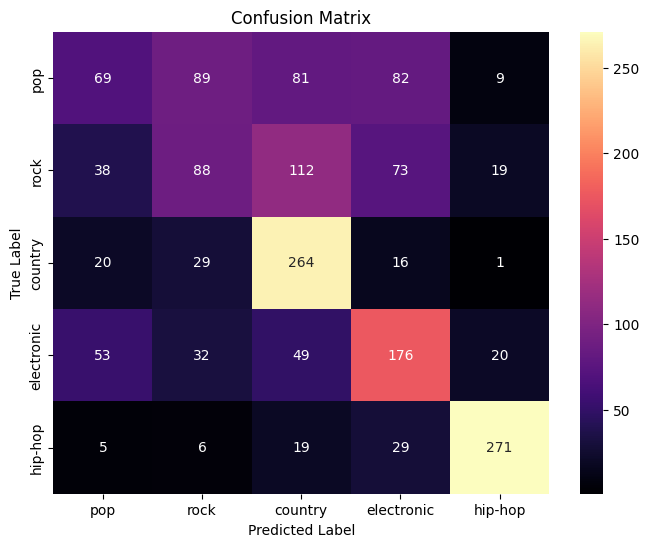

In [86]:
# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [87]:
# Classification Report
class_report = classification_report(y_test_classes, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.21      0.27       330
           1       0.36      0.27      0.31       330
           2       0.50      0.80      0.62       330
           3       0.47      0.53      0.50       330
           4       0.85      0.82      0.83       330

    accuracy                           0.53      1650
   macro avg       0.51      0.53      0.50      1650
weighted avg       0.51      0.53      0.50      1650



## Implementing Convolutional Neural Network Model

In [88]:
def func_model():
  input_layer = Input(shape=(None,), dtype="int64")
  embedding = Embedding(vocabSize + 1, 64)(input_layer)
  conv1 = Conv1D(128, 5, activation="relu")(embedding)
  pool1 = MaxPooling1D(5)(conv1)
  conv2 = Conv1D(128, 5, activation="relu")(pool1)
  pool2 = MaxPooling1D(5)(conv2)
  conv3 = Conv1D(128, 5, activation="relu")(pool2)
  g_pool = GlobalMaxPooling1D()(conv3)
  dense1 = Dense(128, activation="relu")(g_pool)
  dropout = Dropout(0.2)(dense1)
  output_layer = Dense(5, activation="softmax")(dropout)
  model = Model(inputs=input_layer, outputs=output_layer)
  return model

In [89]:
model_CNN = func_model()

In [90]:
model_CNN.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 64)       │     1,764,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,987,141 (7.58 MB)

 Trainable params: 1,987,141 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_CNN.keras',  # Path to save the model file with .keras extension
    monitor='val_loss',                 # Metric to monitor
    verbose=1,                          # Verbosity mode (0 or 1)
    save_best_only=True,                # Only save the best model
    mode='min',                         # Mode for the monitored metric
    save_weights_only=False,            # Whether to save only the model weights
    save_freq='epoch'                   # Save every epoch
)

In [92]:
model_CNN.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [93]:
history = model_CNN.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose = 1,
    callbacks=[checkpoint]
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.2504 - loss: 1.5812
Epoch 1: val_loss improved from inf to 1.47811, saving model to model_checkpoint_CNN.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - accuracy: 0.2529 - loss: 1.5791 - val_accuracy: 0.3223 - val_loss: 1.4781
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.3454 - loss: 1.4448
Epoch 2: val_loss improved from 1.47811 to 1.37765, saving model to model_checkpoint_CNN.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.3458 - loss: 1.4445 - val_accuracy: 0.3595 - val_loss: 1.3776
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.3809 - loss: 1.3562
Epoch 3: val_loss improved from 1.37765 to 1.36418, saving model to model_checkpoint_CNN.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 385ms/step - accuracy: 0.3808 - loss: 1.3558 - val_accuracy: 0.3813 - val_loss: 1.3642
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.3992 - loss: 1.2977
Epoch 4: val_loss did no

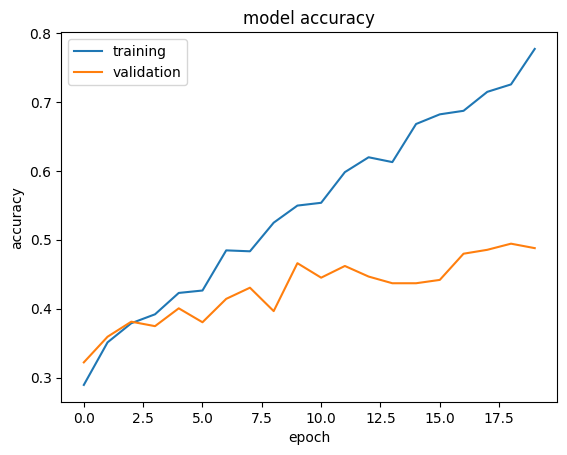

In [94]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [95]:
model_CNN.load_weights('model_checkpoint_CNN.keras')

In [96]:
predict_genre(model_CNN, song_lyrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[0.10217346, 0.27231482, 0.0073297 , 0.23587978, 0.38230222]],
      dtype=float32)

In [97]:
# Predict class probabilities
y_pred_proba = model_CNN.predict(X_test)  # Ensure your CNN model has a softmax at the last layer for multi-class

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [98]:
# Calculate Accuracy (already done during evaluation)
cnn_loss, cnn_accuracy = model_CNN.evaluate(X_test, y_test)

# Calculate additional metrics
precision = precision_score(y_test_classes, y_pred, average='weighted')
recall = recall_score(y_test_classes, y_pred, average='weighted')
f1 = f1_score(y_test_classes, y_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred)

# Precision Score
precision = precision_score(y_test, y_pred_classes, average='weighted')

# Recall Score
recall = recall_score(y_test, y_pred_classes, average='weighted')

# F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred_classes)

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_classes)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_positive_proba))
rss = np.sum(np.square(y_test - y_pred_positive_proba))
mape = mean_absolute_percentage_error(y_test, y_pred_positive_proba)

# Extract TP, TN, FP, FN
TP = conf_matrix[1, 1]  # True Positive: correctly predicted event values
TN = conf_matrix[0, 0]  # True Negative: correctly predicted no-event values
FP = conf_matrix[0, 1]  # False Positive: incorrectly predicted event values
FN = conf_matrix[1, 0]  # False Negative: incorrectly predicted no-event values

# Calculate Sensitivity (Recall or True Positive Rate)
sensitivity = TP / float(TP + FN)

# Calculate Specificity (True Negative Rate)
specificity = TN / float(TN + FP)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4694 - loss: 1.3116


In [99]:
cnn_stats = {
    'Accuracy': cnn_accuracy * 100,
    'Loss': cnn_loss * 100,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Matthews Correlation Coefficient': mcc,
    'Cohen\'s Kappa': kappa,
    'RMSE': rmse,
    'RSS': rss,
    'MAPE': mape,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}

In [100]:
print(f"CNN Model \n--------------------------------")
print(f"Accuracy: {cnn_accuracy * 100:.2f}%")
print(f"Loss: {cnn_loss * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Matthew's Correlation Coefficient: {mcc:.3f}")
print(f"Cohen's Kappa: {kappa:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"RSS: {rss:.3f}")
print(f"MAPE: {mape:.3f}")
print(f"Sensitivity (Recall or True Positive Rate): {sensitivity:.3f}")
print(f"Specificity (True Negative Rate): {specificity:.3f}")

CNN Model 
--------------------------------
Accuracy: 45.94%
Loss: 131.25%
Precision: 0.47
Recall: 0.459
F1-Score: 0.459
Matthew's Correlation Coefficient: 0.326
Cohen's Kappa: 0.324
RMSE: 2.354
RSS: 9146.040
MAPE: 215438399639905.188
Sensitivity (Recall or True Positive Rate): 0.698
Specificity (True Negative Rate): 0.437


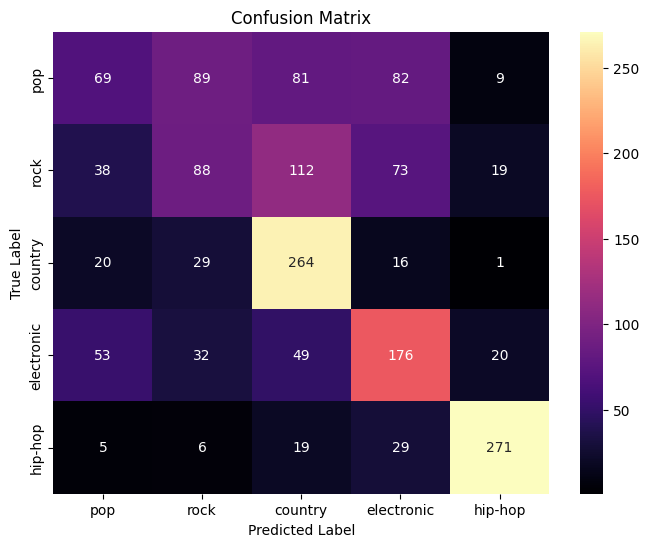

In [101]:
# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [102]:
# Classification Report
class_report = classification_report(y_test_classes, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.21      0.27       330
           1       0.36      0.27      0.31       330
           2       0.50      0.80      0.62       330
           3       0.47      0.53      0.50       330
           4       0.85      0.82      0.83       330

    accuracy                           0.53      1650
   macro avg       0.51      0.53      0.50      1650
weighted avg       0.51      0.53      0.50      1650



## Final Results

In [121]:
all_model_stats = {
    'DNN': dnn_stats,
    'XGBoost': xgb_stats,
    'RNN': rnn_stats,
    'CNN': cnn_stats,
}

# Create DataFrame
stats_df = pd.DataFrame(all_model_stats)

In [124]:
print("Model statistics and comparison")
stats_df

Model statistics and comparison


,DNN,XGBoost,RNN,CNN
Accuracy,6.454545e+01,6.763636e+01,5.260606e+01,4.593939e+01
Loss,9.581860e+01,8.529715e+01,1.184740e+02,1.312451e+02
Precision,6.549911e-01,6.549911e-01,5.102892e-01,4.683584e-01
Recall,6.454545e-01,6.454545e-01,5.260606e-01,4.593939e-01
F1-Score,6.484542e-01,6.484542e-01,5.049110e-01,4.588690e-01
Matthews Correlation Coefficient,5.577092e-01,5.577092e-01,5.577092e-01,3.263536e-01
Cohen's Kappa,5.568182e-01,5.568182e-01,5.568182e-01,3.242424e-01
RMSE,1.211560e+00,1.211560e+00,2.354369e+00,2.354369e+00
RSS,2.422000e+03,2.422000e+03,9.146040e+03,9.146040e+03
MAPE,8.270247e+14,8.270247e+14,2.154384e+14,2.154384e+14
